In [1]:
"""
Download dataset:

https://www.kaggle.com/rounakbanik/the-movies-dataset
"""
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings; warnings.filterwarnings('ignore');

import os
import scipy
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt

SOURCE = os.path.expanduser("~/RecSys_Classification/")

#Read Data
ratings_path = os.path.join(
    SOURCE,
    'data/ratings.csv')
ratings = pd.read_csv(ratings_path)

item_f_path = os.path.join(
    SOURCE,
    'data/movies_metadata.csv')
item_features = pd.read_csv(item_f_path)

credits_path = os.path.join(
    SOURCE,
    'data/credits.csv')
credits = pd.read_csv(credits_path)

# Get data from which we will obtain item features

In [2]:
#Make index both int
item_features['id'] = pd.to_numeric(
    item_features['id'], 
    errors='coerce')
credits['id'] = pd.to_numeric(
    credits['id'], 
    errors='coerce')
#Make sure there is not null indexes
credits = credits[~credits['id'].isnull()]
item_features = item_features[~item_features['id'].isnull()]

#Make sure there is no duplicates
item_features.drop_duplicates('id', inplace=True)
credits.drop_duplicates('id', inplace=True)

#Set indexes
item_features.index = item_features['id']
credits.index = credits['id']

#Make sure movie ids are consistent in both datasets
idx = set(
    item_features.index.tolist()
).intersection(
    credits.index.tolist()
)
idx = list(idx)

item_features = item_features[item_features.index.isin(idx)]
credits = credits[credits.index.isin(idx)]

#Just to keep my paranoia controled I like to keep both datasets nicely matching line by line.
credits = credits.loc[item_features.index]

#putting all together
item_features = pd.concat([
    item_features,
    credits],
    axis=1)
item_features = item_features.drop('id', axis=1)

#Get list of movie genres
def get_genres(x):
    try:
        x = literal_eval(x)
        x = [y['name'] for y in x]
        
        if len(x) == 0:
            return np.nan
        else:
            return x
    except:
        return np.nan
item_features['genres'] = item_features['genres'].apply(get_genres)

#Exclude movies without genres at all
item_features = item_features[~item_features['genres'].isnull()]

#Discretize genres: select the movie-genre which is most popular
genres = item_features['genres'].tolist()
genres_flat = [y for x in genres for y in x]
genres_flat = pd.Series(genres_flat)
genre_popularity = genres_flat.value_counts()

def select_most_pop_genre(x):
    return genre_popularity.loc[x].argmax()

item_features['genres'] = item_features['genres'].apply(select_most_pop_genre)

#Exclude movies that have rare genres
genre_count = item_features['genres'].value_counts()
valid_genres = genre_count[genre_count > 400].index.tolist()

item_features = item_features[item_features['genres'].isin(valid_genres)]

#Only consider ratings for which we have movie features
ratings = ratings[ratings['movieId'].isin(item_features.index)]

KeyboardInterrupt: 

# Filter items not too popular and users with not too much history

- To avoid to recommend very popular items I won't even use them to train.
- There are users that watch a huge amount of movies, I won't relly on them to train my recommender.

This is how my ratings look like:

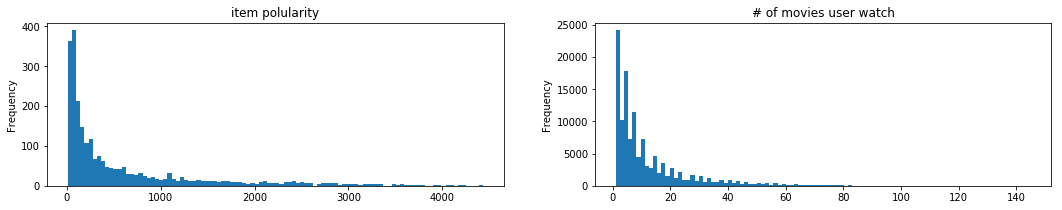

In [77]:
fig, ax = plt.subplots(1, 2)

item_vc = ratings['movieId'].value_counts()
item_vc = item_vc[item_vc > 100]
valid_items = item_vc[item_vc < 6000].index

user_vc = ratings['userId'].value_counts()
user_vc = user_vc[user_vc > 10]
valid_users = user_vc[user_vc < 200].index

ratings = ratings[ratings['movieId'].isin(valid_items)]
ratings = ratings[ratings['userId'].isin(valid_users)]

item_vc = ratings['movieId'].value_counts()
user_vc = ratings['userId'].value_counts()

item_vc.loc[valid_items].plot(kind='hist', bins=100, ax=ax[0], title='item polularity')
user_vc.loc[valid_users].plot(kind='hist', bins=100, ax=ax[1], title='# of movies user watch')

fig.set_size_inches(18, 3)

# Getting movie genres

# Item Features

Get numeric item features

- year
- crew/cast sizes
- vote_count, vote_avg, budget, popularity and revenue
- spoken language
- genre

In [78]:
#Year
item_features['year'] = pd.to_datetime(
    item_features['release_date'], 
    errors='coerce').dt.year

In [79]:
def count_json(x):
    try:
        return len(literal_eval(x))
    except:
        return []

#Crew and Cast Sizes
for f in ['cast', 'crew']:
    new_feature = "%s_size" % f
    item_features[new_feature] = item_features[f].apply(count_json)

In [80]:
#Ensure Numeric
for f in ['vote_count', 'vote_average', 'budget', 'popularity', 'revenue']:
    item_features[f] = pd.to_numeric(
        item_features[f], 
        errors='coerce')

In [81]:
#Language
def parse_spok_lan(x):
    try:
        return [y['name'] for y in literal_eval(x)]
    except:
        return []

lang_f = 'spoken_languages'
item_features[lang_f] = item_features[lang_f].apply(parse_spok_lan)

languages = item_features[lang_f]
all_languages = list(set([y for x in languages for y in x]))
print("|".join(all_languages))

all_languages = pd.Series(all_languages)

spoken_languages = item_features[lang_f].apply(
    lambda x: all_languages.isin(x))

spoken_languages.columns = all_languages
spoken_languages.index = item_features.index

spoken_languages = spoken_languages.add_prefix("language_")

|Latin|فارسی|Dansk|Esperanto|Afrikaans|български език|Bosanski|Bokmål|Pусский|Deutsch|suomi|עִבְרִית|English|ქართული|??????|Hausa|беларуская мова|Gaeilge|Català|বাংলা|ภาษาไทย|Français|Español|اردو|Norsk|Galego|Italiano|Lietuvikai|广州话 / 廣州話|普通话|ਪੰਜਾਬੀ|ozbek|Türkçe|ελληνικά|Azərbaycan|қазақ|Português|Eesti|Slovenčina|Latviešu|Hrvatski|Tiếng Việt|Cymraeg|हिन्दी|Slovenščina|Magyar|Bahasa melayu|Nederlands|Bahasa indonesia|Íslenska|Bamanankan|தமிழ்|తెలుగు|shqip|العربية|Wolof|Kinyarwanda|한국어/조선말|svenska|?????|Srpski|No Language|پښتو|Kiswahili|Română|Polski|isiZulu|Malti|Fulfulde|euskera|Somali|Český|Український|日本語


In [82]:
#genre
genre_one_hot = pd.get_dummies(item_features['genres'])
genre_one_hot = genre_one_hot.add_prefix('genre_')

In [83]:
#Concat Num.Features and Language Features
numeric_features = item_features[[
    'budget',
    'popularity',
    'revenue',
    'runtime',
    'vote_average',
    'vote_count',
    'year',
    'cast_size',
    'crew_size']]

i_features = pd.concat([
    numeric_features,
    genre_one_hot,
    spoken_languages.astype(int)],
    axis=1)

i_features.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,year,cast_size,crew_size,genre_Action,...,language_Română,language_Polski,language_isiZulu,language_Malti,language_Fulfulde,language_euskera,language_Somali,language_Český,language_Український,language_日本語
id,,,,,,,,,,,,,,,,,,,,,
862.0,30000000,21.946943,373554033.0,81.0,7.7,5415.0,1995.0,13,106,0,...,0,0,0,0,0,0,0,0,0,0
8844.0,65000000,17.015539,262797249.0,104.0,6.9,2413.0,1995.0,26,16,0,...,0,0,0,0,0,0,0,0,0,0
15602.0,0,11.712900,0.0,101.0,6.5,92.0,1995.0,7,4,0,...,0,0,0,0,0,0,0,0,0,0
31357.0,16000000,3.859495,81452156.0,127.0,6.1,34.0,1995.0,10,10,0,...,0,0,0,0,0,0,0,0,0,0
11862.0,0,8.387519,76578911.0,106.0,5.7,173.0,1995.0,12,7,0,...,0,0,0,0,0,0,0,0,0,0


# Concat. movie title in transactions

In [84]:
item_id_to_name = item_features['title'].to_dict()

def get_title(x):
    if x in item_id_to_name: 
        return item_id_to_name[x]
    else:
        np.nan

ratings['title'] = ratings['movieId'].apply(get_title)

# Split data in Train/Test

- assign new sequential ids


In [85]:
ORI_ID_USER = 'userId'
ORI_ID_ITEM = 'movieId'

SEQ_ID_USER = 'user_id'
SEQ_ID_ITEM = 'item_id'

In [86]:
ratings['id_transaction'] = range(ratings.shape[0])

ratings['timestamp'] = pd.to_datetime(
    ratings['timestamp'], 
    unit='s')

split_date = pd.datetime(
    year=2016,
    month=1,
    day=1)

train = ratings[ratings['timestamp'] < split_date]
test = ratings[ratings['timestamp'] >= split_date]

# Num. of ratings per year in Train/Test

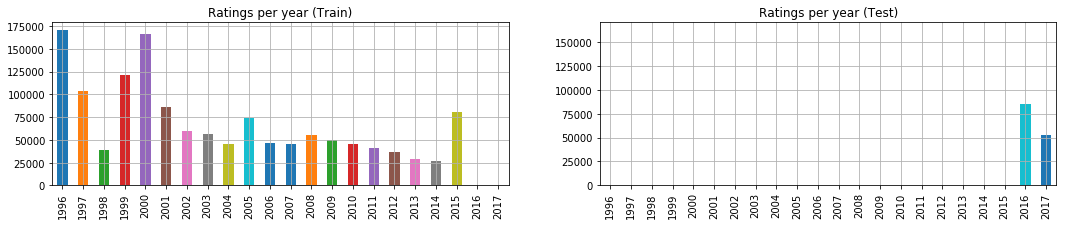

In [87]:
unique_years = list(sorted(ratings['timestamp'].dt.year.unique()))

fig, ax = plt.subplots(1, 2)

year_train_vc = train['timestamp'].dt.year.value_counts()
year_train_vc.loc[unique_years].plot(
    kind='bar',
    title='Ratings per year (Train)',
    grid=True,
    ax=ax[0],
    figsize=(18, 3));

year_test_vc = test['timestamp'].dt.year.value_counts()
year_test_vc = year_test_vc.loc[unique_years].fillna(0)

year_test_vc.plot(
    kind='bar',
    title='Ratings per year (Test)',
    ax=ax[1],
    grid=True,
    ylim=(0, year_train_vc.max()),
    figsize=(18, 3));

## Summary

In [88]:
print("Train data:\t%s (#users: %s #items:%s)" % (
    train.shape[0],
    train[ORI_ID_USER].nunique(),
    train[ORI_ID_ITEM].nunique()
))

print("Test data:\t%s (#users: %s #items:%s)" % (
    test.shape[0],
    test[ORI_ID_USER].nunique(),
    test[ORI_ID_ITEM].nunique()
))

Train data:	1377335 (#users: 113048 #items:2472)
Test data:	136919 (#users: 13488 #items:2235)


# Assign new sequencial user/item IDs

In [89]:
IDorigin_IDuser = {}
IDuser_IDorigin = {}
for id_user, id_origin in enumerate(ratings[ORI_ID_USER].unique()):
    IDorigin_IDuser[id_origin] = id_user
    IDuser_IDorigin[id_user] = id_origin

IDorigin_IDitem = {}
IDitem_IDorigin = {}
for id_item, id_origin in enumerate(ratings[ORI_ID_ITEM].unique()):
    IDorigin_IDitem[id_origin] = id_item
    IDitem_IDorigin[id_item] = id_origin

num_users = len(IDorigin_IDuser)
num_items = len(IDorigin_IDitem)

ratings[SEQ_ID_USER] = ratings[ORI_ID_USER].apply(lambda x: IDorigin_IDuser[x])
ratings[SEQ_ID_ITEM] = ratings[ORI_ID_ITEM].apply(lambda x: IDorigin_IDitem[x])

train = ratings[ratings['id_transaction'].isin(train['id_transaction'])]
test = ratings[ratings['id_transaction'].isin(test['id_transaction'])]

print("#Users:%s #Items:%s sparsity: %s" % (
    num_users,
    num_items,
    round(1 - (ratings.shape[0] / (num_users * num_items)), 5)
))

#Users:123981 #Items:2479 sparsity: 0.99507


In [90]:
train.to_hdf(
    os.path.join(SOURCE, "data/train.hdf" ), key='train')

test.to_hdf(
    os.path.join(SOURCE, "data/test.hdf" ), key='test')

## Build item catalog

In [91]:
item_features = item_features[item_features.index.isin( ratings[ORI_ID_ITEM].unique() )]
item_features[SEQ_ID_ITEM] = pd.Series(item_features.index).apply(
    lambda x: IDorigin_IDitem[x]).values

item_cat_f = [
    'title', 
    'popularity', 
    'genres',
    'year',
    SEQ_ID_ITEM]

item_catalog = item_features[item_cat_f].copy()
item_catalog.drop_duplicates(
    list(set(item_cat_f)-set(['genres'])),
    inplace=True)

item_catalog.index = item_catalog[SEQ_ID_ITEM]

item_catalog.sort_values(SEQ_ID_ITEM, inplace=True)
print(item_catalog.shape)
item_catalog.head()

(2479, 5)


,title,popularity,genres,year,item_id
item_id,,,,,
0,The 400 Blows,7.268688,Drama,1959.0,0
1,Caesar Must Die,9.737921,Drama,2012.0,1
2,Talk to Her,6.648278,Drama,2002.0,2
3,The Matrix Revolutions,15.368205,Thriller,2003.0,3
4,Batman & Robin,17.038824,Action,1997.0,4


In [92]:
item_catalog.to_hdf(
    os.path.join(SOURCE, "data/item_catalogue.hdf" ),
    key='item_catalogue')

# Save item features including new IDs

In [93]:
i_features = i_features[i_features.index.isin(IDorigin_IDitem)]

i_features[ORI_ID_ITEM] = i_features.index
i_features[SEQ_ID_ITEM] = i_features[ORI_ID_ITEM].apply(lambda x: IDorigin_IDitem[x])

i_features.fillna(0, inplace=True)
i_features.to_hdf(
    os.path.join(SOURCE, 'data/i_features.hdf'),
    key='i_features')